# Inspiration

Crime incident reports are provided by Boston Police Department (BPD) to document the initial details surrounding an incident to which BPD officers respond. This is a dataset containing records from the new crime incident report system, which includes a reduced set of fields focused on capturing the type of incident as well as when and where it occurred. 

What types of crimes are most common? Where are different types of crimes most likely to occur? Does the frequency of crimes change over the day? Week? Year?

# Importing the data frame into note book

The data is provided by Analyze Boston. Records begin in June 14, 2015 and continue to September 3, 2018

Use python pandas to import the note book

Google colab needs extra functions to import. Data csv was downloaded from Keggles into local computer

In [0]:
import pandas as pd
from google.colab import files

Use upload function to brows through the data in the local computer

In [2]:
uploaded = files.upload()

In [0]:
for fn in uploaded.keys():
  print('User uploaded file = "{name}" with length {length} bytes'.format(
    name=fn, length=len(uploaded[fn])))

User uploaded file = "crime.csv" with length 57969510 bytes


Import io to decode the data

In [0]:
import io

UTF-8 decoding did not work with this set. Therefore, 'windows-1254' was used

---
Otherwise use UTF-8 instead


In [0]:
data=pd.read_csv(io.StringIO(uploaded['crime.csv'].decode('windows-1254')))

# Data Wrangling

Take a look at data set

---
Present only the first 10 rows

In [0]:
data.head(10)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"
5,I182070936,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,C11,398,NaN,2018-09-03 21:09:00,2018,9,Monday,21,Part Three,TALBOT AVE,42.290196,-71.071590,"(42.29019621, -71.07159012)"
6,I182070933,724,Auto Theft,AUTO THEFT,B2,330,NaN,2018-09-03 21:25:00,2018,9,Monday,21,Part One,NORMANDY ST,42.306072,-71.082733,"(42.30607218, -71.08273260)"
7,I182070932,3301,Verbal Disputes,VERBAL DISPUTE,B2,584,NaN,2018-09-03 20:39:37,2018,9,Monday,20,Part Three,LAWN ST,42.327016,-71.105551,"(42.32701648, -71.10555088)"
8,I182070931,301,Robbery,ROBBERY - STREET,C6,177,NaN,2018-09-03 20:48:00,2018,9,Monday,20,Part One,MASSACHUSETTS AVE,42.331521,-71.070853,"(42.33152148, -71.07085307)"
9,I182070929,3301,Verbal Disputes,VERBAL DISPUTE,C11,364,NaN,2018-09-03 20:38:00,2018,9,Monday,20,Part Three,LESLIE ST,42.295147,-71.058608,"(42.29514664, -71.05860832)"


There are some redundant data. Some data are duplicated. They needed to be cleaned first

Import severel other packages including the matlibplot and seaborn 

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

Check how many duplicate data are there

In [0]:
print ('Number of duplicates in data: {}'.format(
    sum(data.duplicated(subset=['INCIDENT_NUMBER'], keep=False))))

Number of duplicates in data: 64079


Remove the dupliicate data from the data frame

In [0]:
data = data.drop_duplicates(subset=['INCIDENT_NUMBER'], keep='first').copy()

Now check how many data are left to analyze

In [0]:
data.shape

(282517, 17)

In [0]:
# Check how many values are null in each column
def show_missing_data(data):
    missing_data = data.isnull().sum().reset_index()
    missing_data.columns = ['column_name', 'missing_count']
    missing_data['filling_factor'] = (data.shape[0] - missing_data['missing_count']) / data.shape[0] * 100
    return missing_data.sort_values('filling_factor').reset_index(drop=True)

show_missing_data(data)[:6]

,column_name,missing_count,filling_factor
0,SHOOTING,281891,0.22
1,Lat,17204,93.91
2,Long,17204,93.91
3,STREET,9268,96.72
4,DISTRICT,1583,99.44
5,UCR_PART,54,99.98


Shooting seems to be the least filled column

---

Usually if there are lot of null rows in a column then it get deleted 

However, shooting data are important to our analysis therefore we will keep it.

Lets delete some of the unwanted columns 

In [0]:
data.drop('STREET', axis=1, inplace=True)

In [0]:
data.drop('INCIDENT_NUMBER', axis=1, inplace=True)

Check how many columns are there to analyze

In [0]:
data.shape

(282517, 15)

In [0]:
data.head()

,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,Lat,Long,Location
0,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,42.36,-71.14,"(42.35779134, -71.13937053)"
1,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,42.31,-71.06,"(42.30682138, -71.06030035)"
2,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,42.35,-71.07,"(42.34658879, -71.07242943)"
3,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,42.33,-71.08,"(42.33418175, -71.07866441)"
4,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,42.28,-71.09,"(42.27536542, -71.09036101)"


# Data visualization

Lest make a map of all the crime location

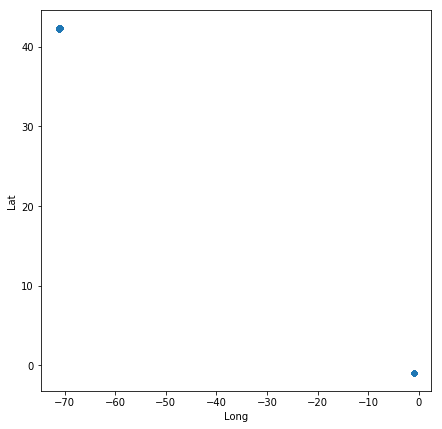

In [0]:
# Building out our final viz:
data.plot(kind = "scatter",
             x = 'Long',
             y = 'Lat',
             figsize = (7,7)
             )

Make a histogram to check which days have most crimes

In [0]:
data.columns

Index(['OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT',
       'REPORTING_AREA', 'SHOOTING', 'OCCURRED_ON_DATE', 'YEAR', 'MONTH',
       'DAY_OF_WEEK', 'HOUR', 'UCR_PART', 'Lat', 'Long', 'Location'],
      dtype='object')

Text(0, 0.5, 'number of crimes')

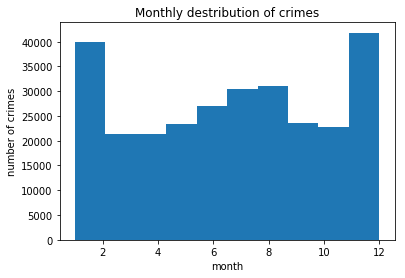

In [0]:
# First we create our plot:
plt.hist(data['MONTH'])

# Then we edit aspects of our plot object:
plt.title("Monthly destribution of crimes")
plt.xlabel("month")
plt.ylabel("number of crimes")

Text(0, 0.5, 'number of crimes')

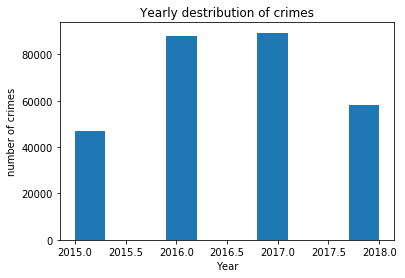

In [0]:
# First we create our plot:
plt.hist(data['YEAR'])

# Then we edit aspects of our plot object:
plt.title("Yearly destribution of crimes")
plt.xlabel("Year")
plt.ylabel("number of crimes")

In [0]:
import re

In [0]:
data['Date_occured'] = data["OCCURRED_ON_DATE"].str.split().str[0]
data['Day_occured']=data['Date_occured'].str.split('-').str[1]
data['Time_occured'] = data["OCCURRED_ON_DATE"].str.split().str[1]
data['Location_Lat']=data["Location"]

In [0]:
# Joining together the continuous and dummy variables into one DataFrame
crime_data = data[['OFFENSE_CODE_GROUP', 'DISTRICT', 'REPORTING_AREA',
       'SHOOTING', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR',
        'Lat', 'Long', 'Location']].join(data[['Day_occured','Time_occured']])

In [0]:
crime_data.head()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,Location,Day_occured,Time_occured
0,Larceny,D14,808,NaN,2018,9,Sunday,13,42.36,-71.14,"(42.35779134, -71.13937053)",09,13:00:00
1,Vandalism,C11,347,NaN,2018,8,Tuesday,0,42.31,-71.06,"(42.30682138, -71.06030035)",08,00:00:00
2,Towed,D4,151,NaN,2018,9,Monday,19,42.35,-71.07,"(42.34658879, -71.07242943)",09,19:27:00
3,Investigate Property,D4,272,NaN,2018,9,Monday,21,42.33,-71.08,"(42.33418175, -71.07866441)",09,21:16:00
4,Investigate Property,B3,421,NaN,2018,9,Monday,21,42.28,-71.09,"(42.27536542, -71.09036101)",09,21:05:00


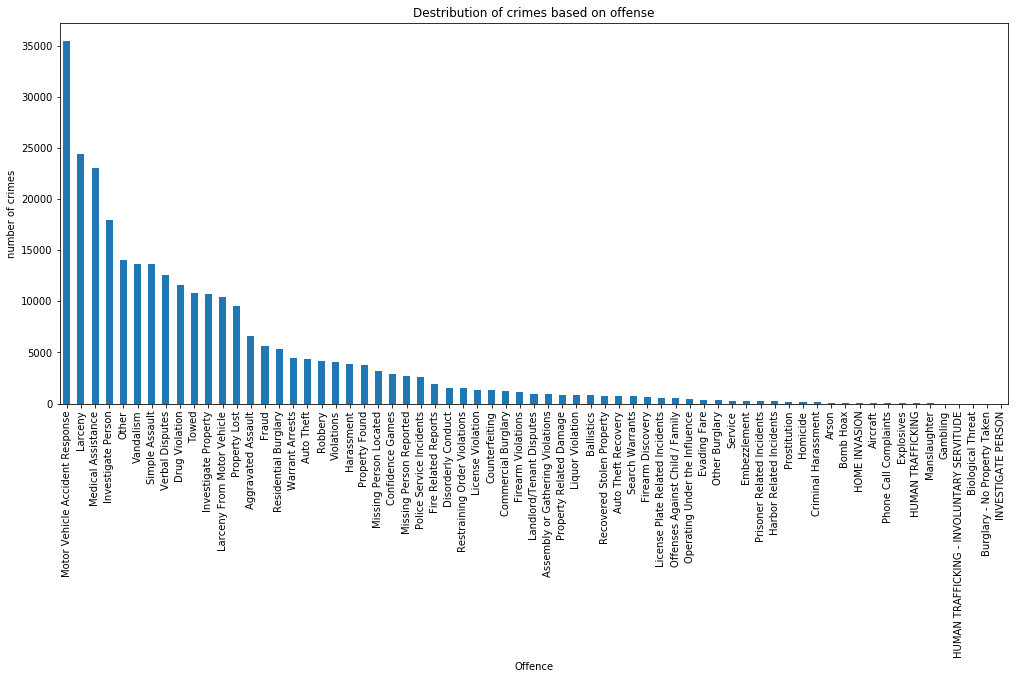

In [0]:
# Bar chart for those values here:
crime_data['OFFENSE_CODE_GROUP'].value_counts().plot(kind = 'bar',figsize = (17,7))
plt.title("Destribution of crimes based on offense")
plt.xlabel("Offence")
plt.ylabel("number of crimes");

In [0]:
data['Lattitude'] = data["Location"].str.split(',').str[0]

In [0]:
data['Longitude'] = data["Location"].str.split(',').str[1]

In [0]:
# Joining together the continuous and dummy variables into one DataFrame
crime_data = data[['OFFENSE_CODE_GROUP', 'DISTRICT', 'REPORTING_AREA',
       'SHOOTING', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR',
         ]].join(data[['Lattitude','Longitude']])

In [0]:
crime_data.head()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lattitude,Longitude
0,Larceny,D14,808,NaN,2018,9,Sunday,13,(42.35779134,-71.13937053)
1,Vandalism,C11,347,NaN,2018,8,Tuesday,0,(42.30682138,-71.06030035)
2,Towed,D4,151,NaN,2018,9,Monday,19,(42.34658879,-71.07242943)
3,Investigate Property,D4,272,NaN,2018,9,Monday,21,(42.33418175,-71.07866441)
4,Investigate Property,B3,421,NaN,2018,9,Monday,21,(42.27536542,-71.09036101)


In [0]:
crime_data["Lattitude1"]=crime_data["Lattitude"].str[1:]

In [0]:
crime_data["Longitude1"]=crime_data["Longitude"].str[:-1]

In [0]:
# Joining together the continuous and dummy variables into one DataFrame
crime_data1 = data[['OFFENSE_CODE_GROUP', 'DISTRICT', 'REPORTING_AREA',
       'SHOOTING', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR',
         ]].join(crime_data[['Lattitude1','Longitude1']])

In [0]:
crime_data1.head()

,OFFENSE_CODE_GROUP,DISTRICT,REPORTING_AREA,SHOOTING,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lattitude1,Longitude1
0,Larceny,D14,808,NaN,2018,9,Sunday,13,42.35779134,-71.13937053
1,Vandalism,C11,347,NaN,2018,8,Tuesday,0,42.30682138,-71.06030035
2,Towed,D4,151,NaN,2018,9,Monday,19,42.34658879,-71.07242943
3,Investigate Property,D4,272,NaN,2018,9,Monday,21,42.33418175,-71.07866441
4,Investigate Property,B3,421,NaN,2018,9,Monday,21,42.27536542,-71.09036101


In [0]:
# one hot encoding using pandas
one_hot_data = pd.get_dummies(crime_data1[['OFFENSE_CODE_GROUP','DISTRICT','DAY_OF_WEEK','SHOOTING']])

In [0]:
crime_data2 = data[['YEAR', 'MONTH', 'HOUR']].join(one_hot_data)

In [0]:
numerical_columns = crime_data2.dtypes[crime_data2.dtypes != 'object'].index
numerical_data = crime_data2[numerical_columns]

In [0]:
from pandas import DataFrame

In [0]:
df = DataFrame(crime_data2)

In [0]:
export_csv = df.to_csv (r'D:\Kaggls\Crimes in boston\crimes-in-boston\export_dataframe.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
open('/content/gdrive/My Drive/data/filename.txt').read()

In [0]:
from google.colab import files
#df.to_csv('export_csv .csv') 
files.download('export_csv.csv')

FileNotFoundError: ignored

Test set and training set 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [0]:
train, test = train_test_split(numerical_data, test_size=0.2)
target_train = train.pop('SHOOTING_Y')
target_test = test.pop('SHOOTING_Y')

In [0]:
print('Train data: {} / {} = {}'.format(len(train), len(crime_data2), float(len(train)/len(crime_data2))))
print('Test data: {} / {} = {}'.format(len(test), len(crime_data2), float(len(test)/len(crime_data2))))

Train data: 226013 / 282517 = 0.7999978762339965
Test data: 56504 / 282517 = 0.20000212376600346


# Regressors from the sklearn

Random forest

In [0]:
forest = RandomForestRegressor(
    max_depth=25,
    min_samples_split=15,
    n_estimators=1000,
    random_state=1)

forest.fit(train, target_train)

The computation of random forest regressor is lot expensive than the neural network in this case

# Calling functions outside the notebook

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('deepnnfunc.py','wb').write(src)


Saving deepnnfunc.py to deepnnfunc (5).py


16372

The function definitions of the neural network is stored in the deepnnfunc note book

In [0]:
import deepnnfunc
from deepnnfunc import *

Train the deep neural network

Before we call the neural network import the following libraries

---



In [0]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
#from dnn_app_utils_v3 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

#Defining the training set and the test set

In [0]:
mm=train.shape[0]
train_x=train.T
target_train1=target_train.values.reshape((mm,1))
train_y=target_train1.T


In [0]:
tt=test.shape[0]
test_x=test.T
target_test1=target_test.values.reshape((tt,1))
test_y=target_test1.T

In [0]:
Print(str(),train_y.shape)
#train_y.shape

(1, 226013)

# Single layer neural network

In [0]:
n_x = train_x.shape[0]     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [0]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        ### START CODE HERE ### (≈ 2 lines of code)
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        ### END CODE HERE ###
        
        # Compute cost
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(A2, Y)
        ### END CODE HERE ###
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### START CODE HERE ### (≈ 2 lines of code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        ### END CODE HERE ###
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        ### START CODE HERE ### (approx. 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # plot the cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.8608585677397038
Cost after iteration 100: 0.015862889611749552
Cost after iteration 200: 0.015862719672371565
Cost after iteration 300: 0.015862549845612004
Cost after iteration 400: 0.0158623801274764
Cost after iteration 500: 0.015862210514001704
Cost after iteration 600: 0.015862041001256034
Cost after iteration 700: 0.01586187158533841
Cost after iteration 800: 0.015861702262378513
Cost after iteration 900: 0.015861533028536434
Cost after iteration 1000: 0.015861363880002442
Cost after iteration 1100: 0.015861194812996717
Cost after iteration 1200: 0.015861025823769144
Cost after iteration 1300: 0.015860856908599088
Cost after iteration 1400: 0.015860688063795137
Cost after iteration 1500: 0.015860519285694902
Cost after iteration 1600: 0.01586035057066479
Cost after iteration 1700: 0.015860181915099775
Cost after iteration 1800: 0.01586001331542321
Cost after iteration 1900: 0.0158598447680866
Cost after iteration 2000: 0.0158596762695694
Cost after iter

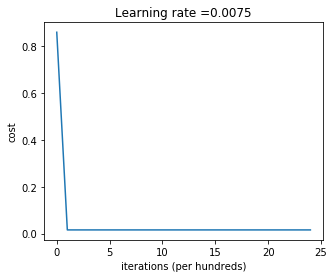

In [0]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

Prediction

# Multi layer deep neural network

In [0]:
import multiprocessing as mp
from queue import Empty

Defining the number of layers 

In [0]:
layers_dims = [train_x.shape[0], 7, 5, 7,8, 1] #  4-layer model

    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

In [0]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009


    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    p=mp.Pool(6)
    
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### START CODE HERE ### (≈ 1 line of code)
        AL, caches = L_model_forward(X, parameters)
        ### END CODE HERE ###
        
        # Compute cost.
        ### START CODE HERE ### (≈ 1 line of code)
        cost = compute_cost(AL, Y)
        ### END CODE HERE ###
    
        # Backward propagation.
        ### START CODE HERE ### (≈ 1 line of code)
        grads = L_model_backward(AL, Y, caches)
        ### END CODE HERE ###
 
        # Update parameters.
        ### START CODE HERE ### (≈ 1 line of code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.537953
Cost after iteration 200: 0.430129
Cost after iteration 300: 0.353492
Cost after iteration 400: 0.297501
Cost after iteration 500: 0.255456
Cost after iteration 600: 0.223073
Cost after iteration 700: 0.197561
Cost after iteration 800: 0.177059
Cost after iteration 900: 0.160295
Cost after iteration 1000: 0.146378
Cost after iteration 1100: 0.134669
Cost after iteration 1200: 0.124703
Cost after iteration 1300: 0.116131
Cost after iteration 1400: 0.108692
Cost after iteration 1500: 0.102181
Cost after iteration 1600: 0.096441
Cost after iteration 1700: 0.091348
Cost after iteration 1800: 0.086801
Cost after iteration 1900: 0.082719
Cost after iteration 2000: 0.079037
Cost after iteration 2100: 0.075700
Cost after iteration 2200: 0.072663
Cost after iteration 2300: 0.069890
Cost after iteration 2400: 0.067347


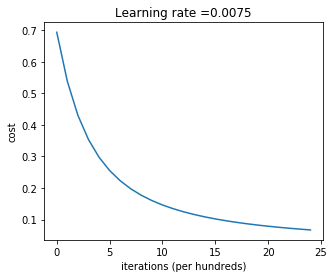

In [0]:
#p=mp.Pool(4)
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Check the accuracy

In [0]:
  # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(parameters, test_x)
    Y_prediction_train = predict(parameters, train_x)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - train_y)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - test_y)) * 100))

train accuracy: 99.77169454854366 %
test accuracy: 99.80532351691916 %
